Epoch 0, Prediction Loss: 374.8501281738281, Physics Loss: 42.96747589111328
Epoch 10, Prediction Loss: 272.1064758300781, Physics Loss: 36.550697326660156
Epoch 20, Prediction Loss: 185.92520141601562, Physics Loss: 30.136329650878906
Epoch 30, Prediction Loss: 116.83924865722656, Physics Loss: 23.784048080444336
Epoch 40, Prediction Loss: 65.30662536621094, Physics Loss: 17.628646850585938
Epoch 50, Prediction Loss: 30.596324920654297, Physics Loss: 11.819974899291992
Epoch 60, Prediction Loss: 10.769562721252441, Physics Loss: 6.589304447174072
Epoch 70, Prediction Loss: 2.475658416748047, Physics Loss: 2.3248226642608643
Epoch 80, Prediction Loss: 0.8019115924835205, Physics Loss: 0.7209612727165222
Epoch 90, Prediction Loss: 0.26422443985939026, Physics Loss: 0.5808297395706177


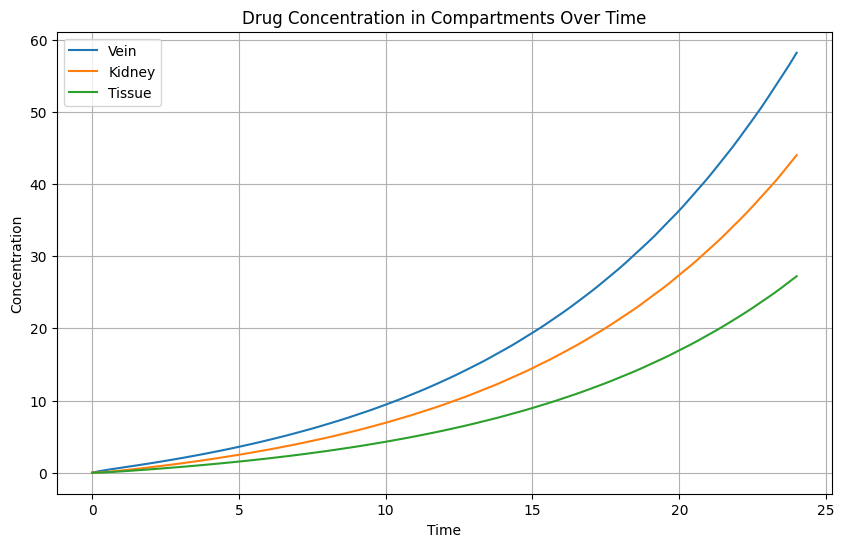

In [2]:
# Required Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ODE System (with Michaelis-Menten kinetics)
def michaelis_menten(C, Vmax, Km):
    return Vmax * C / (Km + C)

def metabol_pbpk_three_comp(t, y, Qk, Qt, Kpk, Kpt, Vmax, Km, Vv, Vk, Vt, Dose):
    V, K, T = y
    metabolism_rate = michaelis_menten(K, Vmax, Km)
    dVdt = (Dose/Vv) - (Qk/Vv)*V + (Qk/Vk)*Kpk*K - (Qt/Vv)*V + (Qt/Vt)*Kpt*T 
    dKdt = (Qk/Vk) * Kpk * V - (Qk/Vk)*K - metabolism_rate
    dTdt = (Qt/Vt) * Kpt * V - (Qt/Vt)*T
    return [dVdt, dKdt, dTdt]

params = {
    "Qk": 1.0, "Qt": 0.5,
    "Kpk": 0.8, "Kpt": 0.5,
    "Vmax": 0.1, "Km": 0.1,
    "Vv": 1.0, "Vk": 0.5, "Vt": 0.3,
    "Dose": 1.0
}
y0 = [0, 0, 0]
t_span = [0, 24] 
t_eval = np.linspace(t_span[0], t_span[1], 100)

sol = solve_ivp(lambda t, y: metabol_pbpk_three_comp(t, y, **params), t_span, y0, t_eval=t_eval)

# PyTorch Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(3, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# Prepare the dataset
X_train = torch.tensor(sol.y[:, :-1].T, dtype=torch.float32)  # Features
y_train = torch.tensor(sol.y[:, 1:].T, dtype=torch.float32)   # Labels

# Model, loss, and optimizer
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Custom physics-based loss function
def physics_loss(output, expected):
    mass_difference = torch.abs(torch.sum(output, dim=1) - torch.sum(expected, dim=1))
    return torch.mean(mass_difference)

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    prediction_loss = criterion(outputs, y_train)
    physics_based_loss = physics_loss(outputs, y_train)
    total_loss = prediction_loss + physics_based_loss
    total_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Prediction Loss: {prediction_loss.item()}, Physics Loss: {physics_based_loss.item()}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_eval, sol.y[0], label='Vein')  # Concentration in Vein over time
plt.plot(t_eval, sol.y[1], label='Kidney')  # Concentration in Kidney over time
plt.plot(t_eval, sol.y[2], label='Tissue')  # Concentration in Tissue over time

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Drug Concentration in Compartments Over Time')
plt.legend()
plt.grid(True)
plt.show()


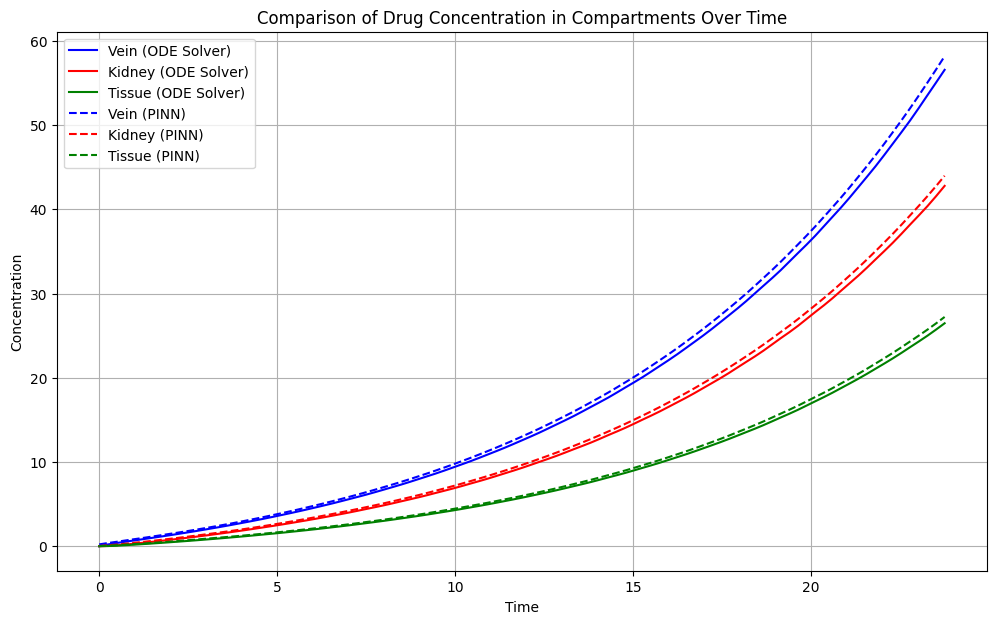

In [4]:
X_train = torch.tensor(sol.y[:, :-1].T, dtype=torch.float32)  
y_train = torch.tensor(sol.y[:, 1:].T, dtype=torch.float32)   

model = SimpleNN()


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


n_epochs = 1000 
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()


model.eval() 
with torch.no_grad():  
    pinn_predictions = model(X_train).numpy()


plt.figure(figsize=(12, 7))


plt.plot(t_eval[:-1], sol.y[0][:-1], 'b-', label='Vein (ODE Solver)')
plt.plot(t_eval[:-1], sol.y[1][:-1], 'r-', label='Kidney (ODE Solver)')
plt.plot(t_eval[:-1], sol.y[2][:-1], 'g-', label='Tissue (ODE Solver)')


plt.plot(t_eval[:-1], pinn_predictions[:, 0], 'b--', label='Vein (PINN)')
plt.plot(t_eval[:-1], pinn_predictions[:, 1], 'r--', label='Kidney (PINN)')
plt.plot(t_eval[:-1], pinn_predictions[:, 2], 'g--', label='Tissue (PINN)')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparison of Drug Concentration in Compartments Over Time')
plt.legend()
plt.grid(True)
plt.show()



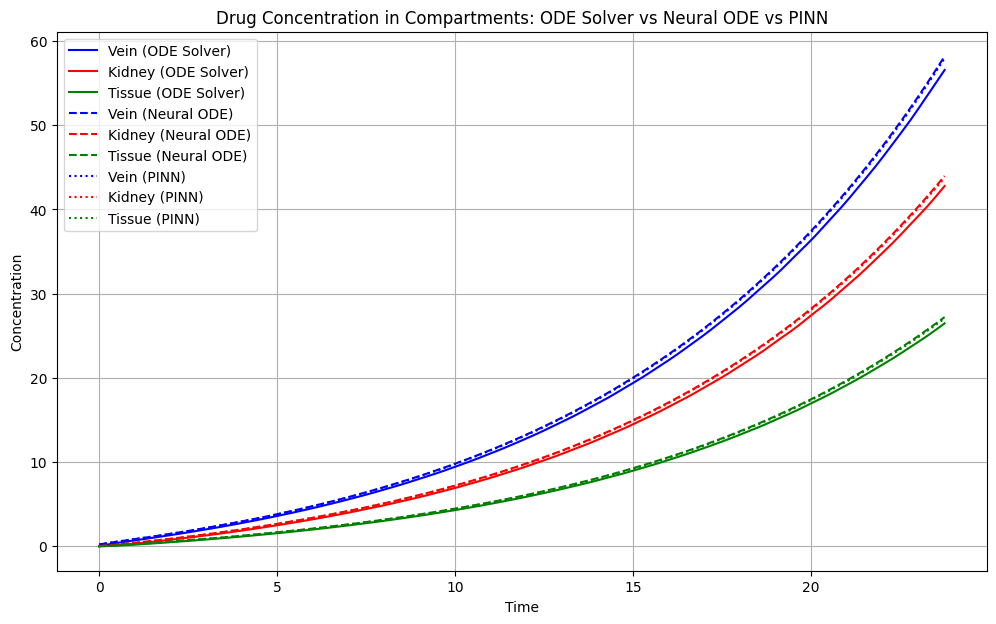

In [8]:

def michaelis_menten(C, Vmax, Km):
    return Vmax * C / (Km + C)

def metabol_pbpk_three_comp(t, y, Qk, Qt, Kpk, Kpt, Vmax, Km, Vv, Vk, Vt, Dose):
    V, K, T = y
    metabolism_rate = michaelis_menten(K, Vmax, Km)
    dVdt = (Dose/Vv) - (Qk/Vv)*V + (Qk/Vk)*Kpk*K - (Qt/Vv)*V + (Qt/Vt)*Kpt*T 
    dKdt = (Qk/Vk) * Kpk * V - (Qk/Vk)*K - metabolism_rate
    dTdt = (Qt/Vt) * Kpt * V - (Qt/Vt)*T
    return [dVdt, dKdt, dTdt]

# Parameters and initial conditions
params = {
    "Qk": 1.0, "Qt": 0.5,
    "Kpk": 0.8, "Kpt": 0.5,
    "Vmax": 0.1, "Km": 0.1,
    "Vv": 1.0, "Vk": 0.5, "Vt": 0.3,
    "Dose": 1.0
}
y0 = [0, 0, 0]
t_span = [0, 24] 
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Solve ODE
sol = solve_ivp(lambda t, y: metabol_pbpk_three_comp(t, y, **params), t_span, y0, t_eval=t_eval)

# Define the neural ODE model
class NeuralODE(nn.Module):
    def __init__(self):
        super(NeuralODE, self).__init__()
        self.linear1 = nn.Linear(3, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 3)
    def forward(self, t, y):
        y = self.relu(self.linear1(y))
        y = self.linear2(y)
        return y

# Train neural ODE without physics-informed loss
neural_ode = NeuralODE()
optimizer = optim.Adam(neural_ode.parameters(), lr=0.01)
criterion = nn.MSELoss()

X_train = torch.tensor(sol.y[:, :-1].T, dtype=torch.float32)
y_train = torch.tensor(sol.y[:, 1:].T, dtype=torch.float32)
for epoch in range(15000):
    optimizer.zero_grad()
    y_pred = neural_ode(t_eval[:-1], X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

# Predict using trained neural ODE
neural_ode.eval()
with torch.no_grad():
    pred_neural_ode = neural_ode(t_eval[:-1], X_train).numpy()

# Train neural ODE with physics-informed loss
def physics_loss(output, expected):
    return torch.mean(torch.abs(torch.sum(output, dim=1) - torch.sum(expected, dim=1)))

for epoch in range(15000):
    optimizer.zero_grad()
    y_pred = neural_ode(t_eval[:-1], X_train)
    loss = criterion(y_pred, y_train) + physics_loss(y_pred, y_train)
    loss.backward()
    optimizer.step()

# Predict using trained PINN
neural_ode.eval()
with torch.no_grad():
    pred_pinn = neural_ode(t_eval[:-1], X_train).numpy()

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(t_eval[:-1], sol.y[0][:-1], 'b-', label='Vein (ODE Solver)')
plt.plot(t_eval[:-1], sol.y[1][:-1], 'r-', label='Kidney (ODE Solver)')
plt.plot(t_eval[:-1], sol.y[2][:-1], 'g-', label='Tissue (ODE Solver)')
plt.plot(t_eval[:-1], pred_neural_ode[:, 0], 'b--', label='Vein (Neural ODE)')
plt.plot(t_eval[:-1], pred_neural_ode[:, 1], 'r--', label='Kidney (Neural ODE)')
plt.plot(t_eval[:-1], pred_neural_ode[:, 2], 'g--', label='Tissue (Neural ODE)')
plt.plot(t_eval[:-1], pred_pinn[:, 0], 'b:', label='Vein (PINN)')
plt.plot(t_eval[:-1], pred_pinn[:, 1], 'r:', label='Kidney (PINN)')
plt.plot(t_eval[:-1], pred_pinn[:, 2], 'g:', label='Tissue (PINN)')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Drug Concentration in Compartments: ODE Solver vs Neural ODE vs PINN')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
pred_pinn

array([[ 2.0576000e-01,  3.8945168e-02, -1.6887188e-03],
       [ 3.8217086e-01,  9.8638676e-02,  4.3368950e-02],
       [ 5.2571976e-01,  1.8312584e-01,  1.1338004e-01],
       [ 6.6378236e-01,  2.8084406e-01,  1.8746343e-01],
       [ 7.9717529e-01,  3.9093480e-01,  2.6035327e-01],
       [ 9.4536513e-01,  5.0087327e-01,  3.2439619e-01],
       [ 1.1079962e+00,  6.0939831e-01,  3.9543945e-01],
       [ 1.2727699e+00,  7.2118872e-01,  4.6740282e-01],
       [ 1.4270155e+00,  8.4034705e-01,  5.3641045e-01],
       [ 1.5913318e+00,  9.6283478e-01,  6.0408527e-01],
       [ 1.7656530e+00,  1.0918044e+00,  6.7950380e-01],
       [ 1.9421999e+00,  1.2245070e+00,  7.5625175e-01],
       [ 2.1165524e+00,  1.3557794e+00,  8.3337218e-01],
       [ 2.2953262e+00,  1.4902292e+00,  9.1244543e-01],
       [ 2.4786758e+00,  1.6280357e+00,  9.9354386e-01],
       [ 2.6668556e+00,  1.7696804e+00,  1.0768007e+00],
       [ 2.8597209e+00,  1.9151616e+00,  1.1623766e+00],
       [ 3.0525789e+00,  2.0606